from [https://github.com/volunt4s/TinyNeRF-pytorch/blob/main/tiny_nerf.py](https://github.com/volunt4s/TinyNeRF-pytorch/blob/main/tiny_nerf.py)


In [167]:
import sys 
sys.path.append('../../')
sys.path.append('../')
import os, sys
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

import radfoam
import mesh_tools as mt
from radfoam_model.mesh_utils import marching_tetrahedra
from pytorch3d.renderer import (
    MeshRasterizer, RasterizationSettings,
    PerspectiveCameras, TexturesVertex, look_at_view_transform
)
from pytorch3d.structures import Meshes

from IPython.display import clear_output
from meshplot import plot
import time

In [168]:
def first_triangle_intersection(ray_origins, ray_directions, boundary_vertices, epsilon=1e-10, tmax=100):
    """based on https://en.wikipedia.org/wiki/Möller–Trumbore_intersection_algorithm
        Input:
            ray_origins: torch.Tensor of shape (N, 3)
            ray_directions: torch.Tensor of shape (N, 3)
            boundary_vertices: torch.Tensor of shape (M, 3, 3)
        Returns:
            intersections: torch.Tensor of shape (N,3) with the new intersection points
            barycentric_coordinates: torch.Tensor of shape (N,3) with the barycentric coordinates of the intersection
            inds: torch.Tensor of shape (N,) with the index of the triangle intersected"""
    edge1 = boundary_vertices[:, 2] - boundary_vertices[:, 0]
    edge2 = boundary_vertices[:, 1] - boundary_vertices[:, 0]
    ray_cross_e2 = torch.cross(ray_directions[:, None, :], edge2[None, :, :], dim=-1)
    det = (edge1[None, :, :]*ray_cross_e2).sum(-1)
    void_inter = torch.zeros_like(det, dtype=torch.bool)
    void_inter[det.abs() < epsilon] = True
    inv_det = 1.0 / det
    s = ray_origins[:, None] - boundary_vertices[None, :, 0]
    u = inv_det * (s*ray_cross_e2).sum(-1)
    void_inter[u<-epsilon] = True
    void_inter[u>1+epsilon] = True
    s_cross_e1 = torch.cross(s, edge1[None, ...], dim=-1)
    v = inv_det * (ray_directions[:, None]*s_cross_e1).sum(-1)
    void_inter[v<-epsilon] = True
    void_inter[u+v>1+epsilon] = True
    t = inv_det * (edge2[None, ...]*s_cross_e1).sum(-1)
    t[void_inter] = tmax
    mini = t.min(-1)
    inds = mini.indices
    values = mini.values
    
    bary_u = u[torch.arange(u.size(0)), inds]
    bary_v = v[torch.arange(v.size(0)), inds]
    bary = torch.column_stack(((1-bary_u-bary_v), bary_v, bary_u))
    inds[values==tmax] = -1
    # bary[inds==-1] = -1
    values[inds==-1] = 0
    return ray_origins+ray_directions*values[:, None], bary, inds

In [169]:
def walk_to_next_tet(triangulation, origins, rays, current_tet_id, epsilon = 1e-10):
    four_adj_faces = triangulation.triangle_faces[current_tet_id]
    four_adj_vertices = triangulation.primal_points[four_adj_faces]

    # find next intersection
    edge1 = four_adj_vertices[:, :, 2] - four_adj_vertices[:, :, 0]
    edge2 = four_adj_vertices[:, :, 1] - four_adj_vertices[:, :, 0]
    ray_cross_e2 = torch.cross(rays[:, None, :], edge2, dim=-1)
    det = (edge1*ray_cross_e2).sum(-1)
    void_inter = torch.zeros_like(det, dtype=torch.bool)
    void_inter[det.abs() < epsilon] = True
    inv_det = 1.0 / det
    s = origins[:, None] - four_adj_vertices[:, :, 0]
    u = inv_det * (s*ray_cross_e2).sum(-1)
    void_inter[u<-epsilon] = True
    void_inter[u>1+epsilon] = True
    s_cross_e1 = torch.cross(s, edge1, dim=-1)
    v = inv_det * (rays[:, None]*s_cross_e1).sum(-1)
    void_inter[v<-epsilon] = True
    void_inter[u+v>1+epsilon] = True
    t = inv_det * (edge2*s_cross_e1).sum(-1)
    t[void_inter] = -1
    mini = t.max(-1) # second intersection
    inds = mini.indices
    values = mini.values

    bary_u = u[torch.arange(u.size(0)), inds]
    bary_v = v[torch.arange(v.size(0)), inds]
    bary = torch.column_stack(((1-bary_u-bary_v), bary_v, bary_u))
    inds[values==-1] = -1
    # bary[inds==-1] = -1
    values[inds==-1] = 0

    next_face = four_adj_faces[torch.arange(u.size(0)), inds]
    next_face[current_tet_id==-1]=-1
    next_tet_id = triangulation.tets_neighbors[current_tet_id][torch.arange(u.size(0)), inds]
    next_tet_id[current_tet_id==-1]=-1
    next_tet_id[inds==-1] = -1
    next_pos = origins + rays*values[:, None]
    
    return next_pos, bary, next_face, next_tet_id

# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


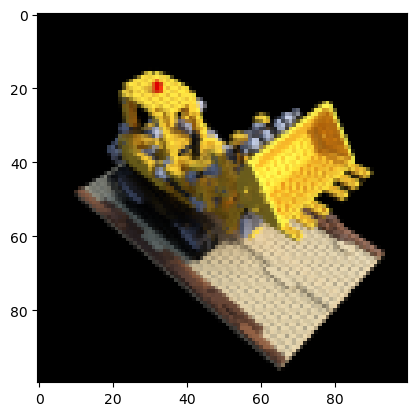

In [170]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

def get_rays(H, W, focal, c2w):
    """
    Get ray origin, direction to each image pixels based on camera pose
    """
    def meshgrid_xy(tensor1, tensor2):
        i, j = torch.meshgrid(tensor1, tensor2, indexing="ij")
        return i.transpose(-1, -2), j.transpose(-1, -2)
    
    i, j = meshgrid_xy(
        torch.arange(W, dtype=torch.float32).to(device),
        torch.arange(H, dtype=torch.float32).to(device)
    )
    dirs = torch.stack([(i-W*0.5)/focal, -(j-H*0.5)/focal, -torch.ones_like(i)], dim=-1).to(device)
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], dim=-1)
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    return rays_o, rays_d

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

In [171]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

images = torch.from_numpy(images).to(device).to(torch.float32)
poses = torch.from_numpy(poses).to(device).to(torch.float32)
focal = torch.from_numpy(focal).to(device).to(torch.float32)

H, W = images.shape[1:3]

# Define test set, training set
testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]


### Delaunay 

In [172]:
class AugmentedTriangulation:
    def __init__(self, primal_points: torch.tensor, primal_color: torch.tensor, primal_densities: torch.tensor) -> None:
        self.triangulation = radfoam.Triangulation(primal_points)
        perm = self.triangulation.permutation().to(torch.long)
        
        self.primal_points = primal_points[perm] 
        self.primal_color = primal_color[perm]
        self.primal_densities = primal_densities[perm]
        
        self.primal_points.requires_grad_(True)
        self.primal_color.requires_grad_(True)
        self.primal_densities.requires_grad_(True)
        self.tree = radfoam.build_aabb_tree(self.primal_points)
        
    @property
    def tets(self):
        return self.triangulation.tets().long()
    
    @property
    def tets_neighbors(self):
        neighs = ((self.triangulation.tet_adjacency().long())//4)
        neighs[neighs>len(self.tets)] = -1
        return neighs
    
    @property
    def triangle_faces(self):
        opp_face = torch.tensor([[1, 2, 3], [0, 3, 2], [0, 1, 3], [0, 2, 1]], device=device)
        return self.tets[:, opp_face]
    
    @property 
    def tet_bary(self):
        return self.primal_points[self.tets].mean(-2)
    
    def signed_volume(self, P, queries):
        '''TODO DEBUG'''
        p1 = P[:,:,1] - P[:,:,0]
        p2 = P[:,:,2] - P[:,:,0]
        p3 = queries[:, None] - P[:,:,0]
        return torch.det(torch.stack((p1, p2, p3), dim=-1))

In [176]:
num_init_points = 3000

primal_points = (torch.rand(num_init_points, 3, device='cuda')-.5)*2.1
primal_colors = torch.rand_like(primal_points)
primal_densities = 2.*torch.ones_like(primal_points[:, :1])

triangulation = AugmentedTriangulation(primal_points, primal_colors, primal_densities)

print('ok')

boundary_faces = triangulation.triangle_faces[triangulation.tets_neighbors==-1]
boundary_tets = torch.arange(len(triangulation.tets), device=device).unsqueeze(-1).expand(-1, 4)[triangulation.tets_neighbors==-1]
boundary_vertices = triangulation.primal_points[boundary_faces]
boundary_normals = F.normalize(torch.cross((boundary_vertices[:, :, 1] - boundary_vertices[:, :, 0]), (boundary_vertices[:, :, 2] - boundary_vertices[:, :, 0]), dim=-1))

len(triangulation.triangle_faces), len(boundary_faces), boundary_vertices.shape

ok


(19643, 174, torch.Size([174, 3, 3]))

In [177]:
mt.export_obj(triangulation.primal_points.cpu().detach().numpy(), boundary_faces.cpu().detach().numpy(), 'boundary.obj')

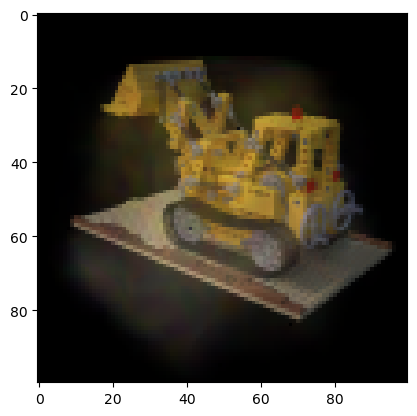

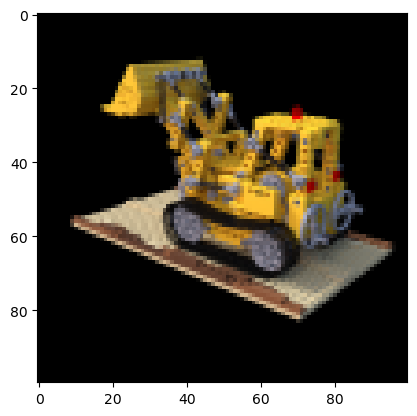

In [193]:


def ray_trace(origins, rays, boundary_vertices, boundary_faces, boundary_tets, triangulation, max_iter=100):
    output_colors = torch.zeros_like(origins)
    transmittance = torch.ones_like(origins[:, 0])
    with torch.no_grad():
        current_pos, bary, current_boundary_id = first_triangle_intersection(origins, rays, boundary_vertices)
        current_tet_id = boundary_tets[current_boundary_id]
        current_tet_id[current_boundary_id==-1] = -1
        current_face = boundary_faces[current_boundary_id]
        current_face[current_boundary_id==-1] = -1
    interp_density = (triangulation.primal_densities[current_face]*bary[..., None]).sum(-2)
    interp_color = (triangulation.primal_color[current_face]*bary[..., None]).sum(-2)
    for i in range(max_iter):
        with torch.no_grad():
            next_pos, bary, new_face, next_tet_id = walk_to_next_tet(triangulation, origins, rays, current_tet_id)

        new_interp_density = (triangulation.primal_densities[new_face]*bary[..., None]).sum(-2)
        new_interp_color = (triangulation.primal_color[new_face]*bary[..., None]).sum(-2)

        integrated_density = (new_interp_density+interp_density)/2.
        integrated_color = (new_interp_color+interp_color)/2.

        diff = ((next_pos - current_pos)**2).sum(-1).sqrt()
        alpha_comp = 1-torch.exp(-integrated_density.squeeze()*diff)
        alpha_comp = alpha_comp*(current_tet_id!=-1)

        current_weight = (transmittance*alpha_comp).unsqueeze(-1)*integrated_color

        output_colors = output_colors+current_weight

        interp_density = new_interp_density
        interp_color = new_interp_color
        current_pos = next_pos
        transmittance = transmittance*(1-alpha_comp)
        current_tet_id = next_tet_id
        
        if current_tet_id.max()==-1:
            break
    return output_colors

ind_i = 4

rays_o, rays_d = get_rays(H, W, focal, poses[ind_i]) 
rays_d /= ((rays_d**2).sum(-1, keepdim=True)).sqrt()   
rays = rays_d.view(-1,3)
origins = rays_o.view(-1,3)

plt.imshow(ray_trace(origins, rays, boundary_vertices, boundary_faces, boundary_tets, triangulation, max_iter=80).cpu().detach().numpy().reshape(H, W, 3)*.5+images[ind_i].cpu().detach().numpy()*.5)
plt.show()

plt.imshow(images[ind_i].cpu().detach().numpy())
plt.show()


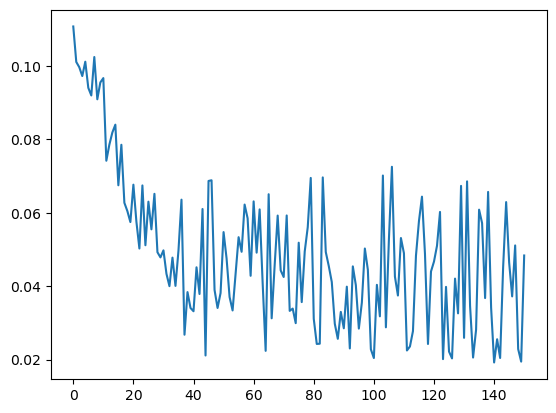

back: 0.3878631591796875
rast: 0.1850590705871582
back: 0.29091382026672363
rast: 0.18732547760009766
back: 0.28861260414123535
rast: 0.18495917320251465
back: 0.28571081161499023
rast: 0.18622589111328125
back: 0.2909402847290039
rast: 0.18669986724853516
back: 0.2860758304595947
rast: 0.18473482131958008


KeyboardInterrupt: 

In [ ]:
L=[]
optimizer = torch.optim.Adam([
    # {'params': primal_points, 'lr': 1e-4},
    {'params': triangulation.primal_color, 'lr': 5e-3},
    {'params': triangulation.primal_densities, 'lr': 5e-2}
])
for i in tqdm(range(500)):
    optimizer.zero_grad()
    img_i = np.random.randint(images.shape[0])
    # img_i=0
    t0 = time.time()
    output_colors = ray_trace(origins, rays, boundary_vertices, boundary_faces, boundary_tets, triangulation, max_iter=80).view(H, W, 3)
    print(f"rast: {time.time()-t0}")
    t0 = time.time()
    loss = ((output_colors-images[img_i])**2).mean()
    L.append(loss.item())
    if i%10==0:
        clear_output(wait=True)
        plt.plot(L)
        plt.show()
    loss.backward()
    optimizer.step()
   
    with torch.no_grad():
        triangulation.primal_densities.clamp_(0, 10000)
        triangulation.primal_color.clamp_(0, 1)
    print(f"back: {time.time()-t0}")

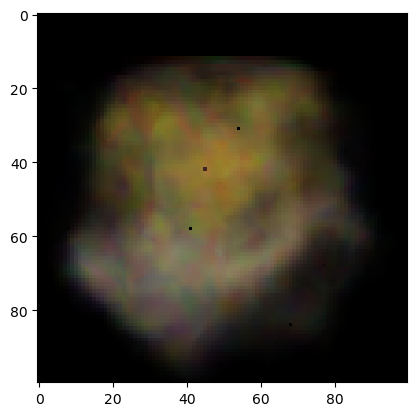

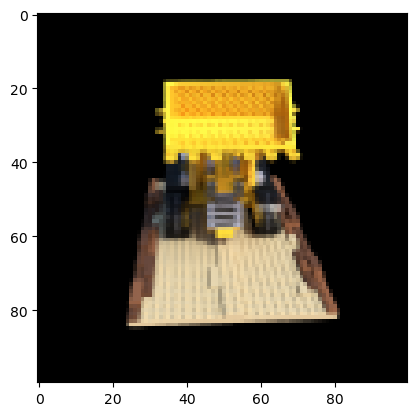

In [180]:

plt.imshow(ray_trace(origins, rays, boundary_vertices, boundary_faces, boundary_tets, triangulation, max_iter=200).cpu().detach().numpy().reshape(H, W, 3))
plt.show()
plt.imshow(images[img_i].cpu().detach().numpy())
plt.show()

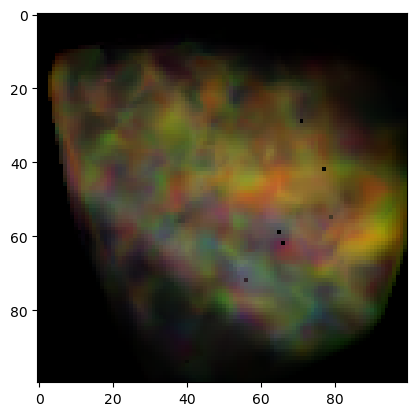

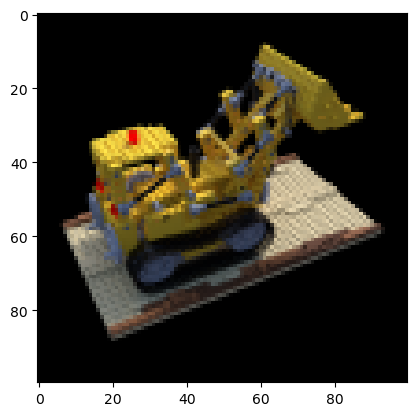

In [187]:
ind_i = 23

rays_o, rays_d = get_rays(H, W, focal, poses[ind_i])    
rays = rays_d.view(-1,3)
origins = rays_o.view(-1,3)

plt.imshow(ray_trace(origins, rays, boundary_vertices, boundary_faces, boundary_tets, triangulation, max_iter=80).cpu().detach().numpy().reshape(H, W, 3))
plt.show()

plt.imshow(images[ind_i].cpu().detach().numpy())
plt.show()


In [99]:
triangulation.primal_densities.squeeze().min(), triangulation.primal_densities.squeeze().max()

(tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(5.8338, device='cuda:0', grad_fn=<MaxBackward1>))

In [101]:
v, f, feat = marching_tetrahedra(triangulation.tets.long(), triangulation.primal_densities.squeeze()-2, triangulation.primal_points, triangulation.primal_color)

plot(v.cpu().detach().numpy(), f.cpu().detach().numpy(), feat.cpu().detach().numpy())
mt.export_obj(v.cpu().detach().numpy(), f.cpu().detach().numpy(), 'lego.obj')


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0634075…